In [1]:
!pip install av

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.7/39.7 MB 43.9 MB/s eta 0:00:00


# Cell 1: 导入库和环境设置

In [2]:
# Cell 1: 导入库和环境设置

# 修复CUDA多进程问题
import multiprocessing as mp
try:
    mp.set_start_method('spawn', force=True)
except RuntimeError:
    pass  # 如果已经设置过，忽略错误

import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random
import warnings
import gc
import json
import time
import sys
from pathlib import Path
from datetime import datetime
warnings.filterwarnings('ignore')

# PyTorch相关
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import torchvision.models as models
from torchvision.io import read_video
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, ReduceLROnPlateau
from torch.cuda.amp import GradScaler, autocast

# 机器学习指标
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, auc, precision_recall_curve, balanced_accuracy_score
)
from sklearn.model_selection import train_test_split

# 系统监控和性能分析
import psutil
import traceback


# 视频处理 (PyAV)
try:
    import av
    PYAV_AVAILABLE = True
    print("✅ PyAV已安装，支持GPU视频处理")
except ImportError:
    PYAV_AVAILABLE = False
    print("⚠️ PyAV未安装，视频处理将回退到CPU模式")

# 数据增强
try:
    import albumentations as A
    from albumentations.pytorch import ToTensorV2
    ALBUMENTATIONS_AVAILABLE = True
except ImportError:
    ALBUMENTATIONS_AVAILABLE = False
    print("警告: albumentations未安装，将使用基础数据增强")

print("✅ 所有库导入完成")

✅ PyAV已安装，支持GPU视频处理
✅ 所有库导入完成


# Cell 2: 全局配置和工具函数

In [3]:
# Cell 2: 全局配置和工具函数 - Kaggle T4 优化版本

def set_seed(seed=42):
    """设置随机种子确保可重复性"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    # Kaggle环境优化：平衡性能和可重复性
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

set_seed(42)

# Kaggle T4 GPU配置
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")

if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1024**3
    print(f"GPU型号: {gpu_name}")
    print(f"GPU内存: {gpu_memory:.1f} GB")
    
    # Kaggle T4 GPU优化配置
    torch.cuda.set_per_process_memory_fraction(0.9)  # 保守内存使用
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
    
    print("✅ Kaggle T4 GPU优化配置已启用")

# 创建必要的目录
for dir_name in ['./data', './models', './logs', './results']:
    os.makedirs(dir_name, exist_ok=True)

# Kaggle环境检测
IS_KAGGLE = os.path.exists('/kaggle')
BASE_DATA_DIR = '/kaggle/input/ff-c23/FaceForensics++_C23' if IS_KAGGLE else './FaceForensics++_C23'

# 统一数据类型配置 - 全部使用FP32提升兼容性
USE_FP32_ONLY = True  # 强制使用FP32，确保最佳兼容性
print(f"数据类型策略: FP32 (兼容性优先)")

print(f"环境: {'Kaggle' if IS_KAGGLE else '本地'}")
print(f"数据基础路径: {BASE_DATA_DIR}")
print("✅ 环境设置完成")

使用设备: cuda
GPU型号: Tesla T4
GPU内存: 14.7 GB
✅ Kaggle T4 GPU优化配置已启用
数据类型策略: FP32 (兼容性优先)
环境: Kaggle
数据基础路径: /kaggle/input/ff-c23/FaceForensics++_C23
✅ 环境设置完成


# Cell 3: 数据处理模块


In [4]:
# Cell 3: GPU加速数据处理模块

def extract_frames_gpu_accelerated(video_path, max_frames=16, target_size=(224, 224),
                                  quality_threshold=20, use_gpu=True):
    """GPU加速的帧提取函数"""
    try:
        # 检查PyAV是否可用
        if not globals().get('PYAV_AVAILABLE', False):
            print(f"PyAV不可用，使用CPU回退处理: {video_path}")
            return extract_frames_cpu_fallback(video_path, max_frames, target_size, quality_threshold)
            
        # 使用torchvision的GPU加速视频读取
        if use_gpu and torch.cuda.is_available():
            device = torch.device('cuda')
        else:
            device = torch.device('cpu')
            
        # 读取视频（torchvision自动处理解码）
        try:
            video_tensor, audio, info = read_video(video_path, pts_unit='sec')
            # video_tensor shape: (T, H, W, C)
        except Exception as e:
            print(f"GPU视频读取失败，回退到CPU: {e}")
            return extract_frames_cpu_fallback(video_path, max_frames, target_size, quality_threshold)
        
        if video_tensor.size(0) == 0:
            return []
            
        # 移动到GPU进行处理
        video_tensor = video_tensor.to(device, non_blocking=True)
        total_frames = video_tensor.size(0)
        
        # 智能帧采样策略
        if total_frames <= max_frames:
            frame_indices = torch.arange(0, total_frames, device=device)
        else:
            # 均匀采样
            step = total_frames / max_frames
            frame_indices = torch.arange(0, total_frames, step, device=device).long()[:max_frames]
        
        # 批量提取帧
        selected_frames = video_tensor[frame_indices]  # (max_frames, H, W, C)
        
        # GPU上进行质量检测（使用Sobel算子代替Laplacian）
        if quality_threshold > 0:
            # 转换为灰度图进行质量检测（先转换为float类型）
            gray_frames = selected_frames.float().mean(dim=-1, keepdim=True)  # (T, H, W, 1)
            gray_frames = gray_frames.permute(0, 3, 1, 2)  # (T, 1, H, W)
            
            # 使用Sobel算子计算图像质量
            sobel_x = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], 
                                 dtype=torch.float32, device=device).view(1, 1, 3, 3)
            sobel_y = torch.tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], 
                                 dtype=torch.float32, device=device).view(1, 1, 3, 3)
            
            grad_x = F.conv2d(gray_frames, sobel_x, padding=1)
            grad_y = F.conv2d(gray_frames, sobel_y, padding=1)
            quality_scores = (grad_x.pow(2) + grad_y.pow(2)).mean(dim=[1, 2, 3])
            
            # 过滤低质量帧
            quality_mask = quality_scores > quality_threshold
            if quality_mask.sum() > 0:
                selected_frames = selected_frames[quality_mask]
            
        # GPU上进行尺寸调整
        selected_frames = selected_frames.permute(0, 3, 1, 2).float()  # (T, C, H, W)
        if selected_frames.size(-1) != target_size[0] or selected_frames.size(-2) != target_size[1]:
            selected_frames = F.interpolate(selected_frames, size=target_size, 
                                          mode='bilinear', align_corners=False)
        
        # 确保帧数足够
        current_frames = selected_frames.size(0)
        if current_frames < max_frames:
            # 重复最后一帧
            if current_frames > 0:
                last_frame = selected_frames[-1:].repeat(max_frames - current_frames, 1, 1, 1)
                selected_frames = torch.cat([selected_frames, last_frame], dim=0)
            else:
                # 创建黑色帧
                selected_frames = torch.zeros(max_frames, 3, target_size[0], target_size[1], 
                                            device=device, dtype=torch.float32)
        
        # 限制到最大帧数
        selected_frames = selected_frames[:max_frames]
        
        # 转换回CPU numpy格式（为了兼容现有代码）
        frames_cpu = selected_frames.permute(0, 2, 3, 1).cpu().numpy().astype(np.uint8)
        frames_list = [frame for frame in frames_cpu]
        
        return frames_list
        
    except Exception as e:
        print(f"GPU帧提取失败，回退到CPU: {e}")
        return extract_frames_cpu_fallback(video_path, max_frames, target_size, quality_threshold)

def extract_frames_cpu_fallback(video_path, max_frames=16, target_size=(224, 224), quality_threshold=20):
    """CPU回退的帧提取函数"""
    cap = cv2.VideoCapture(video_path)
    frames = []

    if not cap.isOpened():
        print(f"无法打开视频: {video_path}")
        return frames

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if total_frames == 0:
        cap.release()
        return frames

    # 均匀采样策略
    if total_frames <= max_frames:
        frame_indices = list(range(0, total_frames, max(1, total_frames // max_frames)))
    else:
        step = max(1, total_frames // max_frames)
        frame_indices = list(range(0, total_frames, step))[:max_frames]

    frame_count = 0
    for frame_idx in frame_indices:
        if frame_count >= max_frames:
            break

        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret, frame = cap.read()

        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            
            # 质量检测
            if quality_threshold > 0:
                gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
                quality = cv2.Laplacian(gray, cv2.CV_64F).var()
                if quality <= quality_threshold:
                    continue
            
            frame = cv2.resize(frame, target_size)
            frames.append(frame)
            frame_count += 1

    cap.release()

    # 如果帧数不足，重复最后一帧
    while len(frames) < max_frames and len(frames) > 0:
        frames.append(frames[-1].copy())

    return frames[:max_frames]

# 为了向后兼容，保留原函数名
def extract_frames_memory_efficient(video_path, max_frames=16, target_size=(224, 224),
                                   quality_threshold=20, skip_frames=3):
    """兼容性包装函数，优先使用GPU加速"""
    return extract_frames_gpu_accelerated(video_path, max_frames, target_size, quality_threshold)

def process_videos_simple(base_data_dir, max_videos_per_class=60, max_frames=16):
    """简化的视频处理函数"""
    data_list = []
    fake_methods = ['Deepfakes', 'Face2Face', 'FaceShifter', 'FaceSwap', 'NeuralTextures']

    print("开始处理真实视频...")
    # 处理真实视频
    original_dir = os.path.join(base_data_dir, 'original')
    if os.path.exists(original_dir):
        video_files = [f for f in os.listdir(original_dir)
                      if f.endswith(('.mp4', '.avi', '.mov'))]
        
        if len(video_files) > max_videos_per_class:
            video_files = random.sample(video_files, max_videos_per_class)

        print(f"找到 {len(video_files)} 个真实视频")

        for video_file in tqdm(video_files, desc="处理真实视频"):
            try:
                video_path = os.path.join(original_dir, video_file)
                frames = extract_frames_memory_efficient(video_path, max_frames)
                
                if len(frames) >= max_frames // 2:  # 至少要有一半的帧
                    data_list.append({
                        'video_path': video_path,
                        'frames': frames,
                        'label': 0,  # 真实视频
                        'method': 'original'
                    })
            except Exception as e:
                print(f"处理视频 {video_file} 时出错: {e}")
                continue

    # 处理伪造视频
    print("开始处理伪造视频...")
    for method in fake_methods:
        method_dir = os.path.join(base_data_dir, method)
        if os.path.exists(method_dir):
            video_files = [f for f in os.listdir(method_dir)
                          if f.endswith(('.mp4', '.avi', '.mov'))]
            
            if len(video_files) > max_videos_per_class:
                video_files = random.sample(video_files, max_videos_per_class)

            print(f"处理 {method}: {len(video_files)} 个视频")

            for video_file in tqdm(video_files, desc=f"处理{method}"):
                try:
                    video_path = os.path.join(method_dir, video_file)
                    frames = extract_frames_memory_efficient(video_path, max_frames)
                    
                    if len(frames) >= max_frames // 2:
                        data_list.append({
                            'video_path': video_path,
                            'frames': frames,
                            'label': 1,  # 伪造视频
                            'method': method
                        })
                except Exception as e:
                    print(f"处理视频 {video_file} 时出错: {e}")
                    continue

    print(f"\n✅ 数据处理完成，共处理 {len(data_list)} 个视频")
    return data_list

def create_dataset_split(data_list, test_size=0.2, val_size=0.1):
    """创建数据集划分"""
    # 分离真实和伪造数据
    real_data = [item for item in data_list if item['label'] == 0]
    fake_data = [item for item in data_list if item['label'] == 1]
    
    print(f"真实视频: {len(real_data)} 个")
    print(f"伪造视频: {len(fake_data)} 个")
    
    # 分别划分真实和伪造数据
    real_train, real_temp = train_test_split(real_data, test_size=test_size+val_size, random_state=42)
    real_val, real_test = train_test_split(real_temp, test_size=test_size/(test_size+val_size), random_state=42)
    
    fake_train, fake_temp = train_test_split(fake_data, test_size=test_size+val_size, random_state=42)
    fake_val, fake_test = train_test_split(fake_temp, test_size=test_size/(test_size+val_size), random_state=42)
    
    # 合并数据
    train_data = real_train + fake_train
    val_data = real_val + fake_val
    test_data = real_test + fake_test
    
    # 打乱数据
    random.shuffle(train_data)
    random.shuffle(val_data)
    random.shuffle(test_data)
    
    return train_data, val_data, test_data

def save_dataset_to_csv(data_list, filename):
    """将数据集保存为CSV文件"""
    df_data = []
    for item in data_list:
        df_data.append({
            'video_path': item['video_path'],
            'label': item['label'],
            'method': item['method'],
            'num_frames': len(item['frames'])
        })
    
    df = pd.DataFrame(df_data)
    df.to_csv(filename, index=False)
    print(f"数据集已保存到: {filename}")
    return df

print("✅ 数据处理函数定义完成")

✅ 数据处理函数定义完成


# Cell 4: 数据集类定义


In [5]:
# Cell 4: 数据集类定义

class DeepfakeVideoDataset(Dataset):
    """深度伪造视频数据集类 - Kaggle T4 优化版本"""
    
    def __init__(self, csv_file=None, data_list=None, transform=None, max_frames=16, 
                 gpu_preprocessing=True, cache_frames=False):
        if csv_file is not None:
            self.df = pd.read_csv(csv_file)
            self.data_list = None
        elif data_list is not None:
            self.data_list = data_list
            self.df = None
        else:
            raise ValueError("必须提供csv_file或data_list")
            
        self.transform = transform
        self.max_frames = max_frames
        self.gpu_preprocessing = gpu_preprocessing and torch.cuda.is_available()
        self.cache_frames = cache_frames
        
        # 简化缓存系统 - 仅CPU缓存，避免GPU内存压力
        self.frame_cache = {} if cache_frames else None
        self.cache_hits = 0
        self.cache_misses = 0
        
        # GPU预处理的标准化参数 - 统一使用FP32
        if self.gpu_preprocessing:
            self.mean = torch.tensor([0.485, 0.456, 0.406], device='cuda', dtype=torch.float32)
            self.std = torch.tensor([0.229, 0.224, 0.225], device='cuda', dtype=torch.float32)
            
        print(f"🚀 数据集初始化: GPU预处理={'启用' if self.gpu_preprocessing else '禁用'}, "
              f"缓存={'启用' if self.cache_frames else '禁用'}, 数据类型=FP32")
    
    def __len__(self):
        if self.df is not None:
            return len(self.df)
        return len(self.data_list)
    
    def __getitem__(self, idx):
        if self.data_list is not None:
            # 直接从内存中的数据列表获取
            item = self.data_list[idx]
            frames = item['frames']
            label = item['label']
            video_path = None
        else:
            # 从CSV文件获取路径
            row = self.df.iloc[idx]
            video_path = row['video_path']
            label = row['label']
            frames = None
        
        # 简化的数据处理流程
        if frames is None:
            # 检查CPU缓存
            if self.cache_frames and video_path in self.frame_cache:
                frames = self.frame_cache[video_path]
                self.cache_hits += 1
            else:
                frames = extract_frames_gpu_accelerated(video_path, self.max_frames, target_size=(224, 224))
                self.cache_misses += 1
                # 缓存帧数据
                if self.cache_frames and len(frames) > 0:
                    self.frame_cache[video_path] = frames
        
        # 确保有足够的帧
        if len(frames) == 0:
            frames = [np.zeros((224, 224, 3), dtype=np.uint8) for _ in range(self.max_frames)]
        
        while len(frames) < self.max_frames:
            frames.append(frames[-1].copy() if frames else np.zeros((224, 224, 3), dtype=np.uint8))
        
        frames = frames[:self.max_frames]
        
        # 统一的数据预处理 - 全部使用FP32
        if self.transform:
            frames = [self.transform(frame) for frame in frames]
            video_tensor = torch.stack(frames)
        elif self.gpu_preprocessing:
            # GPU预处理：减少CPU-GPU传输次数
            frames_array = np.stack(frames)  # (T, H, W, C)
            video_tensor = torch.from_numpy(frames_array).permute(0, 3, 1, 2).float()  # (T, C, H, W)
            
            # 移动到GPU并进行预处理 - 统一使用FP32
            video_tensor = video_tensor.to('cuda', non_blocking=True, dtype=torch.float32) / 255.0
            
            # 标准化
            video_tensor = (video_tensor - self.mean.view(1, 3, 1, 1)) / self.std.view(1, 3, 1, 1)
        else:
            # CPU预处理
            frames = [torch.from_numpy(frame).permute(2, 0, 1).float() / 255.0 for frame in frames]
            video_tensor = torch.stack(frames)
        
        # 标签处理 - 统一使用FP32
        label_tensor = torch.tensor(label, dtype=torch.float32)
        if self.gpu_preprocessing:
            label_tensor = label_tensor.to('cuda', non_blocking=True)
        
        return video_tensor, label_tensor
    
    def get_cache_stats(self):
        """获取缓存统计信息"""
        total_requests = self.cache_hits + self.cache_misses
        hit_rate = self.cache_hits / total_requests if total_requests > 0 else 0
        return {
            'cache_hits': self.cache_hits,
            'cache_misses': self.cache_misses,
            'hit_rate': hit_rate,
            'cpu_cache_size': len(self.frame_cache) if self.frame_cache else 0
        }

print("✅ 数据集类定义完成")

✅ 数据集类定义完成


# Cell 5: 模型定义

In [6]:
# Cell 5: 模型定义

class OptimizedDeepfakeDetector(nn.Module):
    """优化的深度伪造检测模型"""
    
    def __init__(self, backbone='resnet50', hidden_dim=512, num_layers=2, 
                 dropout=0.3, use_attention=True):
        super(OptimizedDeepfakeDetector, self).__init__()
        
        self.use_attention = use_attention
        
        # 特征提取器
        if backbone == 'resnet50':
            self.backbone = models.resnet50(pretrained=True)
            feature_dim = self.backbone.fc.in_features
            self.backbone.fc = nn.Identity()
        elif backbone == 'resnet18':
            self.backbone = models.resnet18(pretrained=True)
            feature_dim = self.backbone.fc.in_features
            self.backbone.fc = nn.Identity()
        else:
            raise ValueError(f"不支持的backbone: {backbone}")
        
        # 时序建模
        self.lstm = nn.LSTM(
            input_size=feature_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=True
        )
        
        lstm_output_dim = hidden_dim * 2  # 双向LSTM
        
        # 注意力机制
        if self.use_attention:
            self.attention = nn.MultiheadAttention(
                embed_dim=lstm_output_dim,
                num_heads=8,
                dropout=dropout,
                batch_first=True
            )
        
        # 分类器 (移除 Sigmoid，因为使用 BCEWithLogitsLoss)
        self.classifier = nn.Sequential(
            nn.Linear(lstm_output_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, 1)
        )
        
    def forward(self, x):
        # x shape: (batch_size, num_frames, channels, height, width)
        batch_size, num_frames = x.shape[:2]
        
        # 重塑为 (batch_size * num_frames, channels, height, width)
        x = x.view(-1, *x.shape[2:])
        
        # 特征提取
        features = self.backbone(x)  # (batch_size * num_frames, feature_dim)
        
        # 重塑回时序格式
        features = features.view(batch_size, num_frames, -1)
        
        # LSTM处理
        lstm_out, _ = self.lstm(features)  # (batch_size, num_frames, hidden_dim*2)
        
        # 注意力机制
        attention_weights = None
        if self.use_attention:
            attended_out, attention_weights = self.attention(lstm_out, lstm_out, lstm_out)
            # 全局平均池化
            pooled = attended_out.mean(dim=1)  # (batch_size, hidden_dim*2)
        else:
            # 简单的全局平均池化
            pooled = lstm_out.mean(dim=1)
        
        # 分类
        output = self.classifier(pooled)
        
        return output.squeeze(-1), attention_weights

print("✅ 模型定义完成")

✅ 模型定义完成


# Cell 6: 损失函数和工具类

In [7]:
# Cell 6: 损失函数和工具类

class FocalLoss(nn.Module):
    """焦点损失函数 - 解决类别不平衡问题"""
    
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        # 使用 BCEWithLogitsLoss 以兼容 autocast
        ce_loss = nn.BCEWithLogitsLoss(reduction='none')(inputs, targets)
        # 计算概率用于focal weight
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

class EarlyStopping:
    """早停机制"""
    
    def __init__(self, patience=7, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_loss = None
        self.counter = 0
        self.best_weights = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(model)
        else:
            self.counter += 1

        if self.counter >= self.patience:
            if self.restore_best_weights:
                model.load_state_dict(self.best_weights)
            return True
        return False

    def save_checkpoint(self, model):
        self.best_weights = model.state_dict().copy()

def get_transforms(mode='train', image_size=160):
    """获取数据变换"""
    if mode == 'train':
        return transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((int(image_size * 1.1), int(image_size * 1.1))),
            transforms.RandomCrop((image_size, image_size)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.RandomRotation(degrees=10),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            transforms.RandomErasing(p=0.1, scale=(0.02, 0.1))
        ])
    else:
        return transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

print("✅ 损失函数和工具类定义完成")

✅ 损失函数和工具类定义完成


# Cell 7: 训练和验证函数

In [8]:
# Cell 7: 训练和验证函数

def train_epoch(model, train_loader, criterion, optimizer, device, scaler=None):
    """Kaggle T4 GPU优化的训练函数"""
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []

    pbar = tqdm(train_loader, desc='Training', leave=False)
    
    for batch_idx, (data, target) in enumerate(pbar):
        # 数据传输到GPU
        data = data.to(device, non_blocking=True)
        target = target.to(device, non_blocking=True)
        
        # 梯度清零
        optimizer.zero_grad(set_to_none=True)

        # 前向传播（统一使用FP32）
        output, _ = model(data)
        loss = criterion(output, target)
        
        # 反向传播
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()
        
        # 计算准确率
        with torch.no_grad():
            probs = torch.sigmoid(output)
            predicted = (probs > 0.5).float()
            total += target.size(0)
            correct += (predicted == target).sum().item()

            # 收集预测结果
            all_preds.extend(probs.detach().cpu().numpy())
            all_targets.extend(target.detach().cpu().numpy())

        pbar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'Acc': f'{100.*correct/total:.2f}%'
        })
        
        # 定期清理GPU缓存
        if batch_idx % 50 == 0 and torch.cuda.is_available():
            torch.cuda.empty_cache()

    avg_loss = total_loss / len(train_loader)
    accuracy = 100. * correct / total

    try:
        auc_score = roc_auc_score(all_targets, all_preds)
    except:
        auc_score = 0.0

    return avg_loss, accuracy, auc_score

def validate_epoch(model, val_loader, criterion, device, scaler=None):
    """Kaggle T4 GPU优化的验证函数"""
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        pbar = tqdm(val_loader, desc='Validation', leave=False)

        for batch_idx, (data, target) in enumerate(pbar):
            # 数据传输到GPU
            data = data.to(device, non_blocking=True)
            target = target.to(device, non_blocking=True)
            
            # 前向传播（统一使用FP32）
            output, _ = model(data)
            loss = criterion(output, target)

            total_loss += loss.item()
            
            # 计算准确率
            probs = torch.sigmoid(output)
            predicted = (probs > 0.5).float()
            total += target.size(0)
            correct += (predicted == target).sum().item()

            # 收集预测结果
            all_preds.extend(probs.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

            pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{100.*correct/total:.2f}%'
            })
            
            # 定期清理GPU缓存
            if batch_idx % 50 == 0 and torch.cuda.is_available():
                torch.cuda.empty_cache()

    avg_loss = total_loss / len(val_loader)
    accuracy = 100. * correct / total

    try:
        auc_score = roc_auc_score(all_targets, all_preds)
    except:
        auc_score = 0.0

    return avg_loss, accuracy, auc_score

print("✅ 训练和验证函数定义完成")

✅ 训练和验证函数定义完成


# Cell 8: 评估函数和可视化

In [9]:
# Cell 8: 评估函数和可视化

def evaluate_model_optimized(model, test_loader, criterion, device):
    """优化的模型评估函数"""
    model.eval()
    total_loss = 0.0
    all_predictions = []
    all_targets = []
    all_scores = []
    
    inference_times = []
    
    print("🚀 开始模型评估...")
    
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(tqdm(test_loader, desc="评估进度")):
            data, target = data.to(device), target.to(device)
            
            # 记录推理时间
            start_time = time.time()
            output, attention_weights = model(data)
            inference_time = time.time() - start_time
            inference_times.append(inference_time)
            
            # 计算损失
            loss = criterion(output, target)
            total_loss += loss.item()
            
            # 收集预测结果 (应用 sigmoid 获得概率)
            probs = torch.sigmoid(output)
            predictions = (probs > 0.5).float()
            all_predictions.extend(predictions.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
            all_scores.extend(probs.cpu().numpy())
    
    avg_loss = total_loss / len(test_loader)
    avg_inference_time = np.mean(inference_times)
    total_inference_time = np.sum(inference_times)
    
    print(f"✅ 评估完成")
    print(f"平均损失: {avg_loss:.4f}")
    print(f"平均推理时间: {avg_inference_time*1000:.2f} ms/batch")
    
    return {
        'loss': avg_loss,
        'predictions': np.array(all_predictions),
        'targets': np.array(all_targets),
        'scores': np.array(all_scores),
        'avg_inference_time': avg_inference_time,
        'total_inference_time': total_inference_time
    }

def calculate_comprehensive_metrics(predictions, targets, scores):
    """计算全面的评估指标"""
    # 基础指标
    accuracy = accuracy_score(targets, predictions)
    balanced_acc = balanced_accuracy_score(targets, predictions)
    precision = precision_score(targets, predictions, zero_division=0)
    recall = recall_score(targets, predictions, zero_division=0)
    f1 = f1_score(targets, predictions, zero_division=0)
    
    # 混淆矩阵
    cm = confusion_matrix(targets, predictions)
    tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)
    
    # 特异性和负预测值
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0
    
    # AUC指标
    try:
        auc_roc = roc_auc_score(targets, scores)
    except:
        auc_roc = 0.0
    
    try:
        precision_curve, recall_curve, _ = precision_recall_curve(targets, scores)
        auc_pr = auc(recall_curve, precision_curve)
    except:
        auc_pr = 0.0
    
    return {
        'accuracy': accuracy,
        'balanced_accuracy': balanced_acc,
        'precision': precision,
        'recall': recall,
        'specificity': specificity,
        'f1': f1,
        'auc_roc': auc_roc,
        'auc_pr': auc_pr,
        'npv': npv,
        'confusion_matrix': cm,
        'tn': tn, 'fp': fp, 'fn': fn, 'tp': tp
    }

def plot_enhanced_confusion_matrix(cm, save_path):
    """绘制增强的混淆矩阵"""
    plt.figure(figsize=(10, 8))
    
    # 计算百分比
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    # 创建标签
    labels = np.array([[
        f'{cm[i,j]}\n({cm_percent[i,j]:.1f}%)' 
        for j in range(cm.shape[1])
    ] for i in range(cm.shape[0])])
    
    # 绘制热图
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', 
                xticklabels=['真实', '伪造'],
                yticklabels=['真实', '伪造'],
                cbar_kws={'label': '样本数量'})
    
    plt.title('增强混淆矩阵', fontsize=16, fontweight='bold')
    plt.xlabel('预测标签', fontsize=12)
    plt.ylabel('真实标签', fontsize=12)
    
    # 添加统计信息
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    stats_text = f'准确率: {accuracy:.3f}\n精确率: {precision:.3f}\n召回率: {recall:.3f}\nF1分数: {f1:.3f}'
    plt.text(2.1, 0.5, stats_text, fontsize=10, 
             bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"混淆矩阵已保存到: {save_path}")

def plot_roc_pr_curves(targets, scores, save_path):
    """绘制ROC和PR曲线"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # ROC曲线
    fpr, tpr, _ = roc_curve(targets, scores)
    roc_auc = auc(fpr, tpr)
    
    ax1.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC曲线 (AUC = {roc_auc:.4f})')
    ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('假正率')
    ax1.set_ylabel('真正率')
    ax1.set_title('ROC曲线')
    ax1.legend(loc='lower right')
    ax1.grid(True, alpha=0.3)
    
    # PR曲线
    precision_curve, recall_curve, _ = precision_recall_curve(targets, scores)
    pr_auc = auc(recall_curve, precision_curve)
    
    ax2.plot(recall_curve, precision_curve, color='darkgreen', lw=2,
             label=f'PR曲线 (AUC = {pr_auc:.4f})')
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('召回率')
    ax2.set_ylabel('精确率')
    ax2.set_title('精确率-召回率曲线')
    ax2.legend(loc='lower left')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"ROC/PR曲线已保存到: {save_path}")

print("✅ 评估函数和可视化定义完成")

✅ 评估函数和可视化定义完成


# Cell 9: 数据处理和准备


In [10]:
# Cell 9: 数据处理和准备

# 如果需要处理数据（首次运行）
if not os.path.exists('./data/train.csv'):
    print("📁 开始数据处理...")
    data_list = process_videos_simple(BASE_DATA_DIR, max_videos_per_class=120, max_frames=16)
    
    if len(data_list) == 0:
        print("❌ 未找到数据，请检查数据路径")
        raise ValueError("数据路径错误或数据不存在")
    
    train_data, val_data, test_data = create_dataset_split(data_list)
    
    # 保存数据集
    save_dataset_to_csv(train_data, './data/train.csv')
    save_dataset_to_csv(val_data, './data/val.csv')
    save_dataset_to_csv(test_data, './data/test.csv')
    
    print(f"训练集: {len(train_data)} 个样本")
    print(f"验证集: {len(val_data)} 个样本")
    print(f"测试集: {len(test_data)} 个样本")
else:
    print("📊 数据集已存在，跳过数据处理步骤")
    # 读取现有数据集信息
    train_df = pd.read_csv('./data/train.csv')
    val_df = pd.read_csv('./data/val.csv')
    test_df = pd.read_csv('./data/test.csv')
    
    print(f"训练集: {len(train_df)} 个样本")
    print(f"验证集: {len(val_df)} 个样本")
    print(f"测试集: {len(test_df)} 个样本")
    
    # 显示数据分布
    print("\n数据分布:")
    print("训练集标签分布:")
    print(train_df['label'].value_counts())
    print("\n验证集标签分布:")
    print(val_df['label'].value_counts())
    print("\n测试集标签分布:")
    print(test_df['label'].value_counts())

print("✅ 数据准备完成")

📁 开始数据处理...
开始处理真实视频...
找到 120 个真实视频


处理真实视频: 100%|██████████| 120/120 [10:18<00:00,  5.16s/it]


开始处理伪造视频...
处理 Deepfakes: 120 个视频


处理Deepfakes: 100%|██████████| 120/120 [10:28<00:00,  5.24s/it]


处理 Face2Face: 120 个视频


处理Face2Face: 100%|██████████| 120/120 [09:29<00:00,  4.74s/it]


处理 FaceShifter: 120 个视频


处理FaceShifter: 100%|██████████| 120/120 [11:29<00:00,  5.75s/it]


处理 FaceSwap: 120 个视频


处理FaceSwap: 100%|██████████| 120/120 [09:04<00:00,  4.54s/it]


处理 NeuralTextures: 120 个视频


处理NeuralTextures: 100%|██████████| 120/120 [07:51<00:00,  3.93s/it]


✅ 数据处理完成，共处理 720 个视频
真实视频: 120 个
伪造视频: 600 个
数据集已保存到: ./data/train.csv
数据集已保存到: ./data/val.csv
数据集已保存到: ./data/test.csv
训练集: 502 个样本
验证集: 72 个样本
测试集: 146 个样本
✅ 数据准备完成


# Cell 10: 创建数据加载器


In [11]:
# Cell 10: 创建数据加载器 - Kaggle T4 优化版本

print("📊 创建数据加载器...")

# 简化数据变换 - 使用GPU预处理替代CPU变换
train_transform = None
val_transform = None

print(f"🔧 创建数据集（Kaggle T4优化配置）...")
print(f"📊 数据类型: FP32 (兼容性优先)")

train_dataset = DeepfakeVideoDataset(
    csv_file='./data/train.csv',
    transform=train_transform,
    max_frames=16,
    gpu_preprocessing=True,    # 启用GPU预处理
    cache_frames=False        # 禁用缓存以节省内存
)

val_dataset = DeepfakeVideoDataset(
    csv_file='./data/val.csv',
    transform=val_transform,
    max_frames=16,
    gpu_preprocessing=True,    # 启用GPU预处理
    cache_frames=False        # 禁用缓存以节省内存
)

test_dataset = DeepfakeVideoDataset(
    csv_file='./data/test.csv',
    transform=val_transform,
    max_frames=16,
    gpu_preprocessing=True,    # 启用GPU预处理
    cache_frames=False        # 禁用缓存以节省内存
)
print("✅ 数据集创建完成，已优化Kaggle T4环境配置")

# Kaggle T4 GPU批次大小优化
if torch.cuda.is_available():
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1024**3
    print(f"GPU内存: {gpu_memory:.1f} GB")
    
    # 保守的批次大小设置 - 确保稳定性和兼容性
    if gpu_memory >= 15:  # T4 GPU
        batch_size = 8  # 保守设置，确保稳定
    elif gpu_memory >= 8:
        batch_size = 6
    else:
        batch_size = 4
else:
    batch_size = 4

print(f"使用批次大小: {batch_size} (Kaggle T4优化，稳定性优先)")

# Kaggle环境多进程配置 - 简化版本
if IS_KAGGLE:
    # Kaggle环境：使用单进程避免序列化问题
    num_workers = 0
    prefetch_factor = None
    persistent_workers = False
    print("📝 Kaggle环境：使用单进程模式")
else:
    # 本地环境：使用少量worker
    num_workers = 2
    prefetch_factor = 2
    persistent_workers = False
    print(f"🔥 本地环境：使用 {num_workers} workers")

print(f"数据加载配置: {num_workers} workers, 预取因子: {prefetch_factor}")

# 创建数据加载器 - Kaggle T4优化版本
train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=num_workers,
    pin_memory=False,  # GPU预处理，无需pin_memory
    drop_last=True,
    prefetch_factor=prefetch_factor if num_workers > 0 else None,
    persistent_workers=persistent_workers if num_workers > 0 else False
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=num_workers,
    pin_memory=False,
    prefetch_factor=prefetch_factor if num_workers > 0 else None,
    persistent_workers=persistent_workers if num_workers > 0 else False
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=num_workers,
    pin_memory=False,
    prefetch_factor=prefetch_factor if num_workers > 0 else None,
    persistent_workers=persistent_workers if num_workers > 0 else False
)

print(f"\n📊 数据加载器统计:")
print(f"训练批次数: {len(train_loader)} (批次大小: {batch_size})")
print(f"验证批次数: {len(val_loader)}")
print(f"测试批次数: {len(test_loader)}")
print(f"数据加载worker数: {num_workers}")
print("✅ 数据加载器创建完成")

📊 创建数据加载器...
🔧 创建数据集（Kaggle T4优化配置）...
📊 数据类型: FP32 (兼容性优先)
🚀 数据集初始化: GPU预处理=启用, 缓存=禁用, 数据类型=FP32
🚀 数据集初始化: GPU预处理=启用, 缓存=禁用, 数据类型=FP32
🚀 数据集初始化: GPU预处理=启用, 缓存=禁用, 数据类型=FP32
✅ 数据集创建完成，已优化Kaggle T4环境配置
GPU内存: 14.7 GB
使用批次大小: 6 (Kaggle T4优化，稳定性优先)
📝 Kaggle环境：使用单进程模式
数据加载配置: 0 workers, 预取因子: None

📊 数据加载器统计:
训练批次数: 83 (批次大小: 6)
验证批次数: 12
测试批次数: 25
数据加载worker数: 0
✅ 数据加载器创建完成


# Cell 11: 模型初始化和训练配置


In [12]:
# Cell 11: 模型初始化和训练配置 - Kaggle T4 GPU优化版本

print("🤖 创建和配置模型...")

# 创建模型 - 针对Kaggle T4 GPU优化
model = OptimizedDeepfakeDetector(
    backbone='resnet50',
    hidden_dim=512,      # 适中的隐藏层维度
    num_layers=2,        # 减少LSTM层数
    dropout=0.3,         # 适中的dropout
    use_attention=True
).to(device)

# 单GPU配置
if torch.cuda.is_available():
    torch.cuda.set_per_process_memory_fraction(0.9)
    print("使用单GPU训练")

# 计算模型参数数量
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"模型总参数数量: {total_params:,}")
print(f"可训练参数数量: {trainable_params:,}")
print(f"模型大小估计: {total_params * 4 / 1024**2:.1f} MB")

# 损失函数
criterion = FocalLoss(alpha=0.25, gamma=2.0)
print(f"损失函数: FocalLoss")

# 优化器
base_lr = 0.001
optimizer = optim.AdamW(
    model.parameters(), 
    lr=base_lr,
    weight_decay=0.01
)
print(f"优化器: AdamW (lr={base_lr})")

# 学习率调度器
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=base_lr * 5,
    epochs=20,
    steps_per_epoch=len(train_loader),
    pct_start=0.3,
    anneal_strategy='cos'
)
print(f"学习率调度器: OneCycleLR")

# 早停机制
early_stopping = EarlyStopping(patience=7, min_delta=0.001)
print(f"早停机制: patience=7, min_delta=0.001")

# 训练配置 - 统一使用FP32数据类型
scaler = None
print("数据类型: FP32 (确保兼容性)")

num_epochs = 20
print(f"训练轮数: {num_epochs}")

# 测试模型前向传播
print("\n🔍 测试模型前向传播...")
try:
    model.eval()
    with torch.no_grad():
        sample_batch = next(iter(train_loader))
        videos, labels = sample_batch
        videos, labels = videos.to(device), labels.to(device)
        
        # 前向传播（统一使用FP32）
        outputs, attention_weights = model(videos)
        loss = criterion(outputs, labels)
        
        print(f"输入形状: {videos.shape}")
        print(f"输入数据类型: {videos.dtype}")
        print(f"输出形状: {outputs.shape}")
        print(f"损失值: {loss.item():.4f}")
        
        # 显示概率范围
        probs = torch.sigmoid(outputs)
        print(f"概率范围: [{probs.min():.3f}, {probs.max():.3f}]")
        
        print("✅ 模型前向传播测试成功")
except Exception as e:
    print(f"❌ 模型前向传播测试失败: {e}")
    raise e

print("✅ 模型配置完成，准备开始训练")

🤖 创建和配置模型...


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 175MB/s]


使用单GPU训练
模型总参数数量: 45,156,417
可训练参数数量: 45,156,417
模型大小估计: 172.3 MB
损失函数: FocalLoss
优化器: AdamW (lr=0.001)
学习率调度器: OneCycleLR
早停机制: patience=7, min_delta=0.001
数据类型: FP32 (确保兼容性)
训练轮数: 20

🔍 测试模型前向传播...
输入形状: torch.Size([6, 16, 3, 224, 224])
输入数据类型: torch.float32
输出形状: torch.Size([6])
损失值: 0.0431
概率范围: [0.501, 0.502]
✅ 模型前向传播测试成功
✅ 模型配置完成，准备开始训练


# Cell 12: 模型训练主循环


In [13]:
# Cell 12: 训练循环 - Kaggle T4 GPU优化版本

# 确保模型保存目录存在
os.makedirs('./models', exist_ok=True)

print("🚀 开始训练...")
print(f"📊 训练配置: {len(train_loader)} 个训练批次, {len(val_loader)} 个验证批次")
print(f"🎯 模型参数数量: {sum(p.numel() for p in model.parameters()):,}")
print(f"💾 设备: {device}")
print(f"📦 批次大小: {batch_size}")

if torch.cuda.is_available():
    print(f"🎮 GPU: {torch.cuda.get_device_name(0)}")
    torch.cuda.reset_peak_memory_stats()

# 训练历史记录
train_history = {
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': [],
    'train_auc': [],
    'val_auc': []
}
best_val_loss = float('inf')
best_val_acc = 0.0
best_val_auc = 0.0
best_model_state = None

# 训练循环
print("\n🔄 开始训练循环...")
for epoch in range(num_epochs):
    epoch_start_time = time.time()
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    
    # 训练阶段
    train_loss, train_acc, train_auc = train_epoch(model, train_loader, criterion, optimizer, device, scaler)
    
    # 验证阶段
    val_loss, val_acc, val_auc = validate_epoch(model, val_loader, criterion, device, scaler)
    
    # 记录历史
    train_history['train_loss'].append(train_loss)
    train_history['train_acc'].append(train_acc)
    train_history['train_auc'].append(train_auc)
    train_history['val_loss'].append(val_loss)
    train_history['val_acc'].append(val_acc)
    train_history['val_auc'].append(val_auc)
    
    # 学习率调度
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    
    # 计算epoch时间
    epoch_time = time.time() - epoch_start_time
    
    # 打印结果
    print(f"训练: Loss={train_loss:.4f}, Acc={train_acc:.2f}%, AUC={train_auc:.4f}")
    print(f"验证: Loss={val_loss:.4f}, Acc={val_acc:.2f}%, AUC={val_auc:.4f}")
    print(f"学习率: {current_lr:.2e}, 用时: {epoch_time:.1f}s")
    
    # 保存最佳模型
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_val_acc = val_acc
        best_val_auc = val_auc
        best_model_state = model.state_dict().copy()
        print(f"🎯 新的最佳模型! Loss: {best_val_loss:.4f}, Acc: {best_val_acc:.2f}%, AUC: {best_val_auc:.4f}")
        
        # 保存最佳模型到文件
        torch.save({
            'epoch': epoch,
            'model_state_dict': best_model_state,
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_loss': best_val_loss,
            'best_val_acc': best_val_acc,
            'best_val_auc': best_val_auc,
            'train_history': train_history
        }, './models/best_model.pth')
        print("💾 最佳模型已保存")
    
    # 早停检查
    if early_stopping(val_loss, model):
        print(f"\n⏹️ 早停触发，在第 {epoch+1} 轮停止训练")
        break
    
    # 清理GPU缓存
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

print("\n✅ 训练完成!")
print(f"🏆 最终最佳性能: Loss={best_val_loss:.4f}, Acc={best_val_acc:.2f}%, AUC={best_val_auc:.4f}")
if torch.cuda.is_available():
    print(f"💾 峰值GPU内存使用: {torch.cuda.max_memory_allocated() / 1024**3:.1f}GB")

🚀 开始训练...
📊 训练配置: 83 个训练批次, 12 个验证批次
🎯 模型参数数量: 45,156,417
💾 设备: cuda
📦 批次大小: 6
🎮 GPU: Tesla T4

🔄 开始训练循环...

Epoch 1/20


Training:  22%|██▏       | 18/83 [09:27<31:05, 28.70s/it, Loss=0.0182, Acc=81.48%]

GPU帧提取失败，回退到CPU: CUDA out of memory. Tried to allocate 3.87 GiB. GPU 0 has a total capacity of 14.74 GiB of which 2.76 GiB is free. Process 3714 has 11.98 GiB memory in use. 13.27 GiB allowed; Of the allocated memory 851.05 MiB is allocated by PyTorch, and 11.01 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  49%|████▉     | 41/83 [20:54<20:08, 28.77s/it, Loss=0.0292, Acc=81.71%]

GPU帧提取失败，回退到CPU: CUDA out of memory. Tried to allocate 3.64 GiB. GPU 0 has a total capacity of 14.74 GiB of which 2.86 GiB is free. Process 3714 has 11.88 GiB memory in use. 13.27 GiB allowed; Of the allocated memory 851.05 MiB is allocated by PyTorch, and 10.91 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


训练: Loss=0.0326, Acc=83.53%, AUC=0.4966
验证: Loss=0.0306, Acc=83.33%, AUC=0.3667
学习率: 2.00e-04, 用时: 2966.3s
🎯 新的最佳模型! Loss: 0.0306, Acc: 83.33%, AUC: 0.3667
💾 最佳模型已保存

Epoch 2/20


Training:  96%|█████████▋| 80/83 [40:30<01:57, 39.10s/it, Loss=0.0116, Acc=83.54%]

GPU帧提取失败，回退到CPU: CUDA out of memory. Tried to allocate 4.27 GiB. GPU 0 has a total capacity of 14.74 GiB of which 2.21 GiB is free. Process 3714 has 12.53 GiB memory in use. 13.27 GiB allowed; Of the allocated memory 859.18 MiB is allocated by PyTorch, and 11.55 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Validation:  75%|███████▌  | 9/12 [04:28<01:22, 27.61s/it, Loss=0.0307, Acc=85.19%]

GPU帧提取失败，回退到CPU: CUDA out of memory. Tried to allocate 4.48 GiB. GPU 0 has a total capacity of 14.74 GiB of which 2.23 GiB is free. Process 3714 has 12.51 GiB memory in use. 13.27 GiB allowed; Of the allocated memory 859.18 MiB is allocated by PyTorch, and 11.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


训练: Loss=0.0301, Acc=83.94%, AUC=0.5332
验证: Loss=0.0304, Acc=83.33%, AUC=0.4319
学习率: 2.00e-04, 用时: 2928.8s
🎯 新的最佳模型! Loss: 0.0304, Acc: 83.33%, AUC: 0.4319
💾 最佳模型已保存

Epoch 3/20


Training:   0%|          | 0/83 [00:00<?, ?it/s]

GPU帧提取失败，回退到CPU: CUDA out of memory. Tried to allocate 4.07 GiB. GPU 0 has a total capacity of 14.74 GiB of which 2.23 GiB is free. Process 3714 has 12.51 GiB memory in use. 13.27 GiB allowed; Of the allocated memory 794.86 MiB is allocated by PyTorch, and 11.59 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  13%|█▎        | 11/83 [06:27<36:25, 30.35s/it, Loss=0.0264, Acc=77.27%]

GPU帧提取失败，回退到CPU: CUDA out of memory. Tried to allocate 4.27 GiB. GPU 0 has a total capacity of 14.74 GiB of which 2.35 GiB is free. Process 3714 has 12.39 GiB memory in use. 13.27 GiB allowed; Of the allocated memory 862.05 MiB is allocated by PyTorch, and 11.41 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  94%|█████████▍| 78/83 [39:44<02:59, 35.88s/it, Loss=0.0325, Acc=83.97%]

GPU帧提取失败，回退到CPU: CUDA out of memory. Tried to allocate 4.07 GiB. GPU 0 has a total capacity of 14.74 GiB of which 2.35 GiB is free. Process 3714 has 12.39 GiB memory in use. 13.27 GiB allowed; Of the allocated memory 861.05 MiB is allocated by PyTorch, and 11.41 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  96%|█████████▋| 80/83 [40:56<01:42, 34.25s/it, Loss=0.0682, Acc=83.54%]

GPU帧提取失败，回退到CPU: CUDA out of memory. Tried to allocate 4.42 GiB. GPU 0 has a total capacity of 14.74 GiB of which 2.35 GiB is free. Process 3714 has 12.39 GiB memory in use. 13.27 GiB allowed; Of the allocated memory 861.05 MiB is allocated by PyTorch, and 11.41 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Validation:  75%|███████▌  | 9/12 [04:31<01:23, 27.91s/it, Loss=0.0296, Acc=85.19%]

GPU帧提取失败，回退到CPU: CUDA out of memory. Tried to allocate 4.48 GiB. GPU 0 has a total capacity of 14.74 GiB of which 2.35 GiB is free. Process 3714 has 12.39 GiB memory in use. 13.27 GiB allowed; Of the allocated memory 862.05 MiB is allocated by PyTorch, and 11.41 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


训练: Loss=0.0303, Acc=83.33%, AUC=0.5261
验证: Loss=0.0296, Acc=83.33%, AUC=0.4736
学习率: 2.00e-04, 用时: 2956.4s
🎯 新的最佳模型! Loss: 0.0296, Acc: 83.33%, AUC: 0.4736
💾 最佳模型已保存

Epoch 4/20


Training:  23%|██▎       | 19/83 [08:32<32:23, 30.36s/it, Loss=0.0320, Acc=82.46%]

GPU帧提取失败，回退到CPU: CUDA out of memory. Tried to allocate 4.07 GiB. GPU 0 has a total capacity of 14.74 GiB of which 2.35 GiB is free. Process 3714 has 12.39 GiB memory in use. 13.27 GiB allowed; Of the allocated memory 834.49 MiB is allocated by PyTorch, and 11.44 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  52%|█████▏    | 43/83 [21:42<19:38, 29.47s/it, Loss=0.0116, Acc=84.50%]

GPU帧提取失败，回退到CPU: CUDA out of memory. Tried to allocate 4.27 GiB. GPU 0 has a total capacity of 14.74 GiB of which 2.35 GiB is free. Process 3714 has 12.39 GiB memory in use. 13.27 GiB allowed; Of the allocated memory 843.68 MiB is allocated by PyTorch, and 11.43 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  58%|█████▊    | 48/83 [24:45<18:55, 32.44s/it, Loss=0.0126, Acc=85.76%]

GPU帧提取失败，回退到CPU: CUDA out of memory. Tried to allocate 4.42 GiB. GPU 0 has a total capacity of 14.74 GiB of which 2.35 GiB is free. Process 3714 has 12.39 GiB memory in use. 13.27 GiB allowed; Of the allocated memory 861.05 MiB is allocated by PyTorch, and 11.41 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  95%|█████████▌| 79/83 [40:35<02:14, 33.51s/it, Loss=0.0329, Acc=84.18%]

GPU帧提取失败，回退到CPU: CUDA out of memory. Tried to allocate 4.07 GiB. GPU 0 has a total capacity of 14.74 GiB of which 2.35 GiB is free. Process 3714 has 12.39 GiB memory in use. 13.27 GiB allowed; Of the allocated memory 825.30 MiB is allocated by PyTorch, and 11.45 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Validation:  75%|███████▌  | 9/12 [04:28<01:22, 27.64s/it, Loss=0.0318, Acc=85.19%]

GPU帧提取失败，回退到CPU: CUDA out of memory. Tried to allocate 4.48 GiB. GPU 0 has a total capacity of 14.74 GiB of which 2.35 GiB is free. Process 3714 has 12.39 GiB memory in use. 13.27 GiB allowed; Of the allocated memory 862.05 MiB is allocated by PyTorch, and 11.41 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


训练: Loss=0.0300, Acc=83.53%, AUC=0.5256
验证: Loss=0.0320, Acc=83.33%, AUC=0.3569
学习率: 2.01e-04, 用时: 2961.8s

Epoch 5/20


Training:  14%|█▍        | 12/83 [05:46<33:52, 28.62s/it, Loss=0.0308, Acc=91.67%]

GPU帧提取失败，回退到CPU: CUDA out of memory. Tried to allocate 4.07 GiB. GPU 0 has a total capacity of 14.74 GiB of which 2.35 GiB is free. Process 3714 has 12.39 GiB memory in use. 13.27 GiB allowed; Of the allocated memory 851.86 MiB is allocated by PyTorch, and 11.42 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  31%|███▏      | 26/83 [13:22<30:57, 32.58s/it, Loss=0.0421, Acc=83.97%]

GPU帧提取失败，回退到CPU: CUDA out of memory. Tried to allocate 4.27 GiB. GPU 0 has a total capacity of 14.74 GiB of which 2.35 GiB is free. Process 3714 has 12.39 GiB memory in use. 13.27 GiB allowed; Of the allocated memory 851.86 MiB is allocated by PyTorch, and 11.42 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  42%|████▏     | 35/83 [18:35<26:11, 32.74s/it, Loss=0.0327, Acc=83.81%]

GPU帧提取失败，回退到CPU: CUDA out of memory. Tried to allocate 4.07 GiB. GPU 0 has a total capacity of 14.74 GiB of which 2.35 GiB is free. Process 3714 has 12.39 GiB memory in use. 13.27 GiB allowed; Of the allocated memory 871.24 MiB is allocated by PyTorch, and 11.40 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  94%|█████████▍| 78/83 [40:27<02:22, 28.41s/it, Loss=0.0162, Acc=83.76%]

GPU帧提取失败，回退到CPU: CUDA out of memory. Tried to allocate 4.42 GiB. GPU 0 has a total capacity of 14.74 GiB of which 2.35 GiB is free. Process 3714 has 12.39 GiB memory in use. 13.27 GiB allowed; Of the allocated memory 824.30 MiB is allocated by PyTorch, and 11.45 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Validation:  75%|███████▌  | 9/12 [04:27<01:22, 27.52s/it, Loss=0.0297, Acc=85.19%]

GPU帧提取失败，回退到CPU: CUDA out of memory. Tried to allocate 4.48 GiB. GPU 0 has a total capacity of 14.74 GiB of which 2.35 GiB is free. Process 3714 has 12.39 GiB memory in use. 13.27 GiB allowed; Of the allocated memory 862.05 MiB is allocated by PyTorch, and 11.41 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


训练: Loss=0.0312, Acc=83.73%, AUC=0.4240
验证: Loss=0.0295, Acc=83.33%, AUC=0.5278
学习率: 2.01e-04, 用时: 2961.6s
🎯 新的最佳模型! Loss: 0.0295, Acc: 83.33%, AUC: 0.5278
💾 最佳模型已保存

Epoch 6/20


Training:  43%|████▎     | 36/83 [17:46<24:05, 30.75s/it, Loss=0.0310, Acc=82.41%]

GPU帧提取失败，回退到CPU: CUDA out of memory. Tried to allocate 4.07 GiB. GPU 0 has a total capacity of 14.74 GiB of which 2.35 GiB is free. Process 3714 has 12.39 GiB memory in use. 13.27 GiB allowed; Of the allocated memory 870.24 MiB is allocated by PyTorch, and 11.40 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  46%|████▌     | 38/83 [19:11<27:12, 36.27s/it, Loss=0.0122, Acc=83.33%]

GPU帧提取失败，回退到CPU: CUDA out of memory. Tried to allocate 4.07 GiB. GPU 0 has a total capacity of 14.74 GiB of which 2.35 GiB is free. Process 3714 has 12.39 GiB memory in use. 13.27 GiB allowed; Of the allocated memory 833.49 MiB is allocated by PyTorch, and 11.44 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  57%|█████▋    | 47/83 [24:41<20:34, 34.29s/it, Loss=0.0046, Acc=84.75%]

GPU帧提取失败，回退到CPU: CUDA out of memory. Tried to allocate 4.27 GiB. GPU 0 has a total capacity of 14.74 GiB of which 2.35 GiB is free. Process 3714 has 12.39 GiB memory in use. 13.27 GiB allowed; Of the allocated memory 852.86 MiB is allocated by PyTorch, and 11.42 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  89%|████████▉ | 74/83 [37:46<03:55, 26.21s/it, Loss=0.0307, Acc=84.01%]

GPU帧提取失败，回退到CPU: CUDA out of memory. Tried to allocate 4.42 GiB. GPU 0 has a total capacity of 14.74 GiB of which 2.35 GiB is free. Process 3714 has 12.39 GiB memory in use. 13.27 GiB allowed; Of the allocated memory 851.86 MiB is allocated by PyTorch, and 11.42 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Validation:  75%|███████▌  | 9/12 [04:27<01:22, 27.52s/it, Loss=0.0303, Acc=85.19%]

GPU帧提取失败，回退到CPU: CUDA out of memory. Tried to allocate 4.48 GiB. GPU 0 has a total capacity of 14.74 GiB of which 2.35 GiB is free. Process 3714 has 12.39 GiB memory in use. 13.27 GiB allowed; Of the allocated memory 862.05 MiB is allocated by PyTorch, and 11.41 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


训练: Loss=0.0294, Acc=83.33%, AUC=0.5799
验证: Loss=0.0303, Acc=83.33%, AUC=0.6389
学习率: 2.02e-04, 用时: 2952.3s

Epoch 7/20


Training:  23%|██▎       | 19/83 [10:23<33:07, 31.05s/it, Loss=0.0522, Acc=83.33%]

GPU帧提取失败，回退到CPU: CUDA out of memory. Tried to allocate 4.27 GiB. GPU 0 has a total capacity of 14.74 GiB of which 2.35 GiB is free. Process 3714 has 12.39 GiB memory in use. 13.27 GiB allowed; Of the allocated memory 862.05 MiB is allocated by PyTorch, and 11.41 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  33%|███▎      | 27/83 [14:48<28:23, 30.43s/it, Loss=0.0272, Acc=85.80%]

GPU帧提取失败，回退到CPU: CUDA out of memory. Tried to allocate 4.07 GiB. GPU 0 has a total capacity of 14.74 GiB of which 2.35 GiB is free. Process 3714 has 12.39 GiB memory in use. 13.27 GiB allowed; Of the allocated memory 871.24 MiB is allocated by PyTorch, and 11.40 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  59%|█████▉    | 49/83 [27:16<21:48, 38.48s/it, Loss=0.0433, Acc=81.29%]

GPU帧提取失败，回退到CPU: CUDA out of memory. Tried to allocate 4.42 GiB. GPU 0 has a total capacity of 14.74 GiB of which 2.35 GiB is free. Process 3714 has 12.39 GiB memory in use. 13.27 GiB allowed; Of the allocated memory 862.05 MiB is allocated by PyTorch, and 11.41 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  73%|███████▎  | 61/83 [33:03<09:12, 25.13s/it, Loss=0.0213, Acc=82.79%]

GPU帧提取失败，回退到CPU: CUDA out of memory. Tried to allocate 4.07 GiB. GPU 0 has a total capacity of 14.74 GiB of which 2.35 GiB is free. Process 3714 has 12.39 GiB memory in use. 13.27 GiB allowed; Of the allocated memory 862.05 MiB is allocated by PyTorch, and 11.41 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Validation:  75%|███████▌  | 9/12 [04:28<01:22, 27.61s/it, Loss=0.0326, Acc=85.19%]

GPU帧提取失败，回退到CPU: CUDA out of memory. Tried to allocate 4.48 GiB. GPU 0 has a total capacity of 14.74 GiB of which 2.35 GiB is free. Process 3714 has 12.39 GiB memory in use. 13.27 GiB allowed; Of the allocated memory 862.05 MiB is allocated by PyTorch, and 11.41 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


训练: Loss=0.0302, Acc=83.33%, AUC=0.5208
验证: Loss=0.0308, Acc=83.33%, AUC=0.4722
学习率: 2.02e-04, 用时: 2961.1s

Epoch 8/20


Training:  14%|█▍        | 12/83 [06:32<37:51, 32.00s/it, Loss=0.0123, Acc=83.33%]

GPU帧提取失败，回退到CPU: CUDA out of memory. Tried to allocate 4.07 GiB. GPU 0 has a total capacity of 14.74 GiB of which 2.35 GiB is free. Process 3714 has 12.39 GiB memory in use. 13.27 GiB allowed; Of the allocated memory 851.86 MiB is allocated by PyTorch, and 11.42 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  41%|████      | 34/83 [18:01<23:45, 29.10s/it, Loss=0.0168, Acc=84.80%]

GPU帧提取失败，回退到CPU: CUDA out of memory. Tried to allocate 4.27 GiB. GPU 0 has a total capacity of 14.74 GiB of which 2.35 GiB is free. Process 3714 has 12.39 GiB memory in use. 13.27 GiB allowed; Of the allocated memory 861.05 MiB is allocated by PyTorch, and 11.41 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  49%|████▉     | 41/83 [21:45<21:53, 31.28s/it, Loss=0.0242, Acc=83.74%]

GPU帧提取失败，回退到CPU: CUDA out of memory. Tried to allocate 4.42 GiB. GPU 0 has a total capacity of 14.74 GiB of which 2.35 GiB is free. Process 3714 has 12.39 GiB memory in use. 13.27 GiB allowed; Of the allocated memory 834.49 MiB is allocated by PyTorch, and 11.44 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  75%|███████▍  | 62/83 [33:16<11:45, 33.60s/it, Loss=0.0376, Acc=82.80%]

GPU帧提取失败，回退到CPU: CUDA out of memory. Tried to allocate 4.07 GiB. GPU 0 has a total capacity of 14.74 GiB of which 2.35 GiB is free. Process 3714 has 12.39 GiB memory in use. 13.27 GiB allowed; Of the allocated memory 842.68 MiB is allocated by PyTorch, and 11.43 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Validation:  75%|███████▌  | 9/12 [04:29<01:23, 27.67s/it, Loss=0.0297, Acc=85.19%]

GPU帧提取失败，回退到CPU: CUDA out of memory. Tried to allocate 4.48 GiB. GPU 0 has a total capacity of 14.74 GiB of which 2.35 GiB is free. Process 3714 has 12.39 GiB memory in use. 13.27 GiB allowed; Of the allocated memory 862.05 MiB is allocated by PyTorch, and 11.41 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


训练: Loss=0.0299, Acc=83.53%, AUC=0.5213
验证: Loss=0.0307, Acc=83.33%, AUC=0.4000
学习率: 2.03e-04, 用时: 2948.8s

Epoch 9/20


Training:   1%|          | 1/83 [00:35<48:19, 35.36s/it, Loss=0.0126, Acc=100.00%]

GPU帧提取失败，回退到CPU: CUDA out of memory. Tried to allocate 4.27 GiB. GPU 0 has a total capacity of 14.74 GiB of which 2.35 GiB is free. Process 3714 has 12.39 GiB memory in use. 13.27 GiB allowed; Of the allocated memory 868.55 MiB is allocated by PyTorch, and 11.41 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  61%|██████▏   | 51/83 [25:59<18:15, 34.23s/it, Loss=0.0171, Acc=83.01%]

GPU帧提取失败，回退到CPU: CUDA out of memory. Tried to allocate 4.07 GiB. GPU 0 has a total capacity of 14.74 GiB of which 2.35 GiB is free. Process 3714 has 12.39 GiB memory in use. 13.27 GiB allowed; Of the allocated memory 852.86 MiB is allocated by PyTorch, and 11.42 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  65%|██████▌   | 54/83 [27:51<16:12, 33.53s/it, Loss=0.0392, Acc=83.02%]

GPU帧提取失败，回退到CPU: CUDA out of memory. Tried to allocate 4.42 GiB. GPU 0 has a total capacity of 14.74 GiB of which 2.35 GiB is free. Process 3714 has 12.39 GiB memory in use. 13.27 GiB allowed; Of the allocated memory 842.68 MiB is allocated by PyTorch, and 11.43 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  72%|███████▏  | 60/83 [30:50<10:59, 28.65s/it, Loss=0.0227, Acc=82.50%]

GPU帧提取失败，回退到CPU: CUDA out of memory. Tried to allocate 4.07 GiB. GPU 0 has a total capacity of 14.74 GiB of which 2.35 GiB is free. Process 3714 has 12.39 GiB memory in use. 13.27 GiB allowed; Of the allocated memory 824.30 MiB is allocated by PyTorch, and 11.45 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Validation:  75%|███████▌  | 9/12 [04:27<01:22, 27.51s/it, Loss=0.0290, Acc=85.19%]

GPU帧提取失败，回退到CPU: CUDA out of memory. Tried to allocate 4.48 GiB. GPU 0 has a total capacity of 14.74 GiB of which 2.35 GiB is free. Process 3714 has 12.39 GiB memory in use. 13.27 GiB allowed; Of the allocated memory 862.05 MiB is allocated by PyTorch, and 11.41 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


训练: Loss=0.0296, Acc=83.33%, AUC=0.5552
验证: Loss=0.0305, Acc=83.33%, AUC=0.4681
学习率: 2.04e-04, 用时: 2960.9s

Epoch 10/20


Training:  39%|███▊      | 32/83 [15:57<25:34, 30.09s/it, Loss=0.0396, Acc=81.77%]

GPU帧提取失败，回退到CPU: CUDA out of memory. Tried to allocate 4.07 GiB. GPU 0 has a total capacity of 14.74 GiB of which 2.35 GiB is free. Process 3714 has 12.39 GiB memory in use. 13.27 GiB allowed; Of the allocated memory 851.86 MiB is allocated by PyTorch, and 11.42 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  69%|██████▊   | 57/83 [28:45<11:24, 26.34s/it, Loss=0.0227, Acc=82.75%]

GPU帧提取失败，回退到CPU: CUDA out of memory. Tried to allocate 4.07 GiB. GPU 0 has a total capacity of 14.74 GiB of which 2.35 GiB is free. Process 3714 has 12.39 GiB memory in use. 13.27 GiB allowed; Of the allocated memory 871.24 MiB is allocated by PyTorch, and 11.40 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  92%|█████████▏| 76/83 [38:22<03:00, 25.82s/it, Loss=0.0303, Acc=83.11%]

GPU帧提取失败，回退到CPU: CUDA out of memory. Tried to allocate 4.42 GiB. GPU 0 has a total capacity of 14.74 GiB of which 2.35 GiB is free. Process 3714 has 12.39 GiB memory in use. 13.27 GiB allowed; Of the allocated memory 851.86 MiB is allocated by PyTorch, and 11.42 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  94%|█████████▍| 78/83 [39:42<02:41, 32.26s/it, Loss=0.0129, Acc=83.33%]

GPU帧提取失败，回退到CPU: CUDA out of memory. Tried to allocate 4.27 GiB. GPU 0 has a total capacity of 14.74 GiB of which 2.35 GiB is free. Process 3714 has 12.39 GiB memory in use. 13.27 GiB allowed; Of the allocated memory 833.49 MiB is allocated by PyTorch, and 11.44 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Validation:  75%|███████▌  | 9/12 [04:28<01:22, 27.57s/it, Loss=0.0286, Acc=85.19%]

GPU帧提取失败，回退到CPU: CUDA out of memory. Tried to allocate 4.48 GiB. GPU 0 has a total capacity of 14.74 GiB of which 2.35 GiB is free. Process 3714 has 12.39 GiB memory in use. 13.27 GiB allowed; Of the allocated memory 862.05 MiB is allocated by PyTorch, and 11.41 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


训练: Loss=0.0303, Acc=83.33%, AUC=0.4963
验证: Loss=0.0300, Acc=83.33%, AUC=0.4208
学习率: 2.05e-04, 用时: 2938.6s

Epoch 11/20


Training:   5%|▍         | 4/83 [02:13<49:22, 37.50s/it, Loss=0.0182, Acc=87.50%]

GPU帧提取失败，回退到CPU: CUDA out of memory. Tried to allocate 4.27 GiB. GPU 0 has a total capacity of 14.74 GiB of which 2.35 GiB is free. Process 3714 has 12.39 GiB memory in use. 13.27 GiB allowed; Of the allocated memory 833.49 MiB is allocated by PyTorch, and 11.44 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  52%|█████▏    | 43/83 [22:08<17:37, 26.43s/it, Loss=0.0321, Acc=85.66%]

GPU帧提取失败，回退到CPU: CUDA out of memory. Tried to allocate 4.07 GiB. GPU 0 has a total capacity of 14.74 GiB of which 2.35 GiB is free. Process 3714 has 12.39 GiB memory in use. 13.27 GiB allowed; Of the allocated memory 834.49 MiB is allocated by PyTorch, and 11.44 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  61%|██████▏   | 51/83 [26:05<14:58, 28.07s/it, Loss=0.0172, Acc=86.27%]

GPU帧提取失败，回退到CPU: CUDA out of memory. Tried to allocate 4.07 GiB. GPU 0 has a total capacity of 14.74 GiB of which 2.35 GiB is free. Process 3714 has 12.39 GiB memory in use. 13.27 GiB allowed; Of the allocated memory 852.86 MiB is allocated by PyTorch, and 11.42 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  64%|██████▍   | 53/83 [27:45<18:46, 37.56s/it, Loss=0.0143, Acc=86.48%]

GPU帧提取失败，回退到CPU: CUDA out of memory. Tried to allocate 4.42 GiB. GPU 0 has a total capacity of 14.74 GiB of which 2.35 GiB is free. Process 3714 has 12.39 GiB memory in use. 13.27 GiB allowed; Of the allocated memory 825.30 MiB is allocated by PyTorch, and 11.45 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Validation:  75%|███████▌  | 9/12 [04:31<01:23, 27.97s/it, Loss=0.0301, Acc=85.19%]

GPU帧提取失败，回退到CPU: CUDA out of memory. Tried to allocate 4.48 GiB. GPU 0 has a total capacity of 14.74 GiB of which 2.35 GiB is free. Process 3714 has 12.39 GiB memory in use. 13.27 GiB allowed; Of the allocated memory 862.05 MiB is allocated by PyTorch, and 11.41 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


训练: Loss=0.0294, Acc=83.33%, AUC=0.5670
验证: Loss=0.0324, Acc=83.33%, AUC=0.3375
学习率: 2.06e-04, 用时: 2964.4s

Epoch 12/20


Training:  40%|███▉      | 33/83 [15:35<21:36, 25.93s/it, Loss=0.0449, Acc=82.83%]

GPU帧提取失败，回退到CPU: CUDA out of memory. Tried to allocate 4.07 GiB. GPU 0 has a total capacity of 14.74 GiB of which 2.35 GiB is free. Process 3714 has 12.39 GiB memory in use. 13.27 GiB allowed; Of the allocated memory 862.05 MiB is allocated by PyTorch, and 11.41 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  52%|█████▏    | 43/83 [21:18<21:54, 32.86s/it, Loss=0.0151, Acc=84.11%]

GPU帧提取失败，回退到CPU: CUDA out of memory. Tried to allocate 4.07 GiB. GPU 0 has a total capacity of 14.74 GiB of which 2.35 GiB is free. Process 3714 has 12.39 GiB memory in use. 13.27 GiB allowed; Of the allocated memory 852.86 MiB is allocated by PyTorch, and 11.42 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  54%|█████▍    | 45/83 [22:49<23:57, 37.82s/it, Loss=0.0263, Acc=83.33%]

GPU帧提取失败，回退到CPU: CUDA out of memory. Tried to allocate 4.42 GiB. GPU 0 has a total capacity of 14.74 GiB of which 2.35 GiB is free. Process 3714 has 12.39 GiB memory in use. 13.27 GiB allowed; Of the allocated memory 852.86 MiB is allocated by PyTorch, and 11.42 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  94%|█████████▍| 78/83 [39:52<03:15, 39.15s/it, Loss=0.0336, Acc=82.91%]

GPU帧提取失败，回退到CPU: CUDA out of memory. Tried to allocate 4.27 GiB. GPU 0 has a total capacity of 14.74 GiB of which 2.35 GiB is free. Process 3714 has 12.39 GiB memory in use. 13.27 GiB allowed; Of the allocated memory 851.86 MiB is allocated by PyTorch, and 11.42 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Validation:  75%|███████▌  | 9/12 [04:29<01:23, 27.71s/it, Loss=0.0288, Acc=85.19%]

GPU帧提取失败，回退到CPU: CUDA out of memory. Tried to allocate 4.48 GiB. GPU 0 has a total capacity of 14.74 GiB of which 2.35 GiB is free. Process 3714 has 12.39 GiB memory in use. 13.27 GiB allowed; Of the allocated memory 862.05 MiB is allocated by PyTorch, and 11.41 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


训练: Loss=0.0299, Acc=83.53%, AUC=0.5593
验证: Loss=0.0303, Acc=83.33%, AUC=0.4306
学习率: 2.07e-04, 用时: 2962.7s

⏹️ 早停触发，在第 12 轮停止训练

✅ 训练完成!
🏆 最终最佳性能: Loss=0.0295, Acc=83.33%, AUC=0.5278
💾 峰值GPU内存使用: 11.7GB


# Cell 13: 模型评估和结果分析


📊 开始模型评估...
🔄 加载最佳模型...
✅ 成功加载第 5 轮的最佳模型
最佳验证准确率: 83.33%
最佳验证AUC: 0.5278

🔍 在测试集上评估模型...
🚀 开始模型评估...


评估进度: 100%|██████████| 25/25 [10:45<00:00, 25.80s/it]


✅ 评估完成
平均损失: 0.0295
平均推理时间: 63.25 ms/batch

📈 计算评估指标...

📊 详细评估结果:
测试损失: 0.0295
准确率: 0.8288 (82.88%)
平衡准确率: 0.5000 (50.00%)
精确率: 0.8288
召回率: 1.0000
特异性: 0.0000
F1分数: 0.9064
AUC-ROC: 0.5312
AUC-PR: 0.8300
负预测值: 0.0000

🔍 混淆矩阵分析:
真负例 (TN): 0
假正例 (FP): 25
假负例 (FN): 0
真正例 (TP): 121

⚡ 性能分析:
平均推理时间: 63.25 ms/batch
总推理时间: 1.58 秒
每个样本推理时间: 10.54 ms

📋 类别特定分析:
总样本数: 146
真实视频样本: 25 (17.1%)
伪造视频样本: 121 (82.9%)
真实视频检测准确率: 0.0000 (0.00%)
伪造视频检测准确率: 1.0000 (100.00%)

📊 生成评估图表...


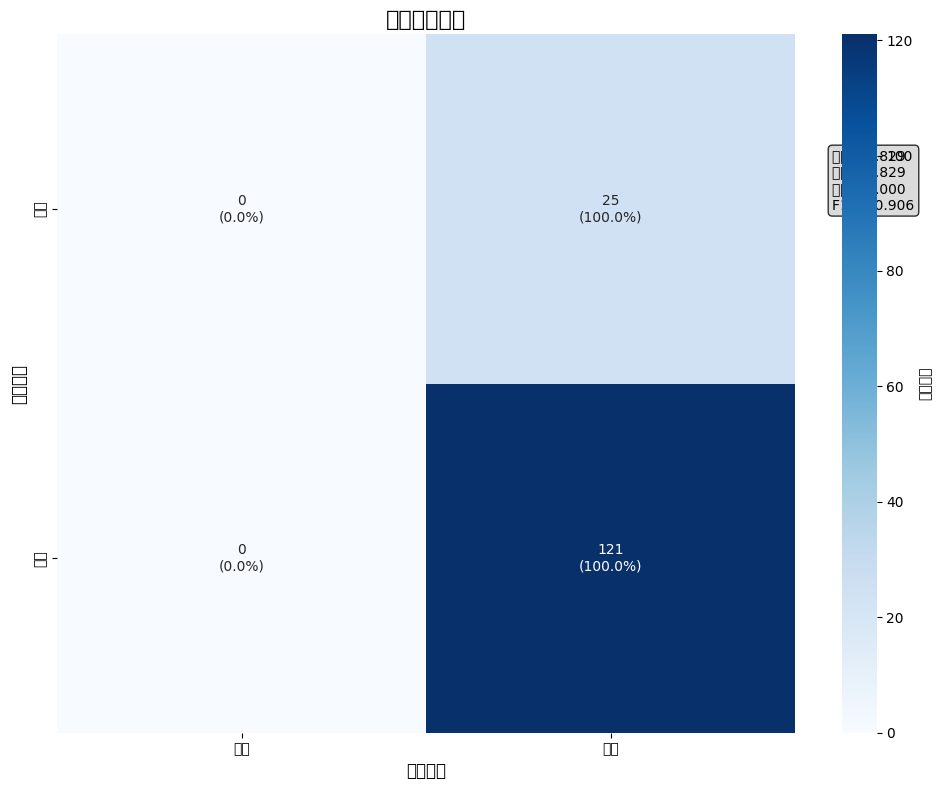

混淆矩阵已保存到: ./results/evaluation/confusion_matrix.png


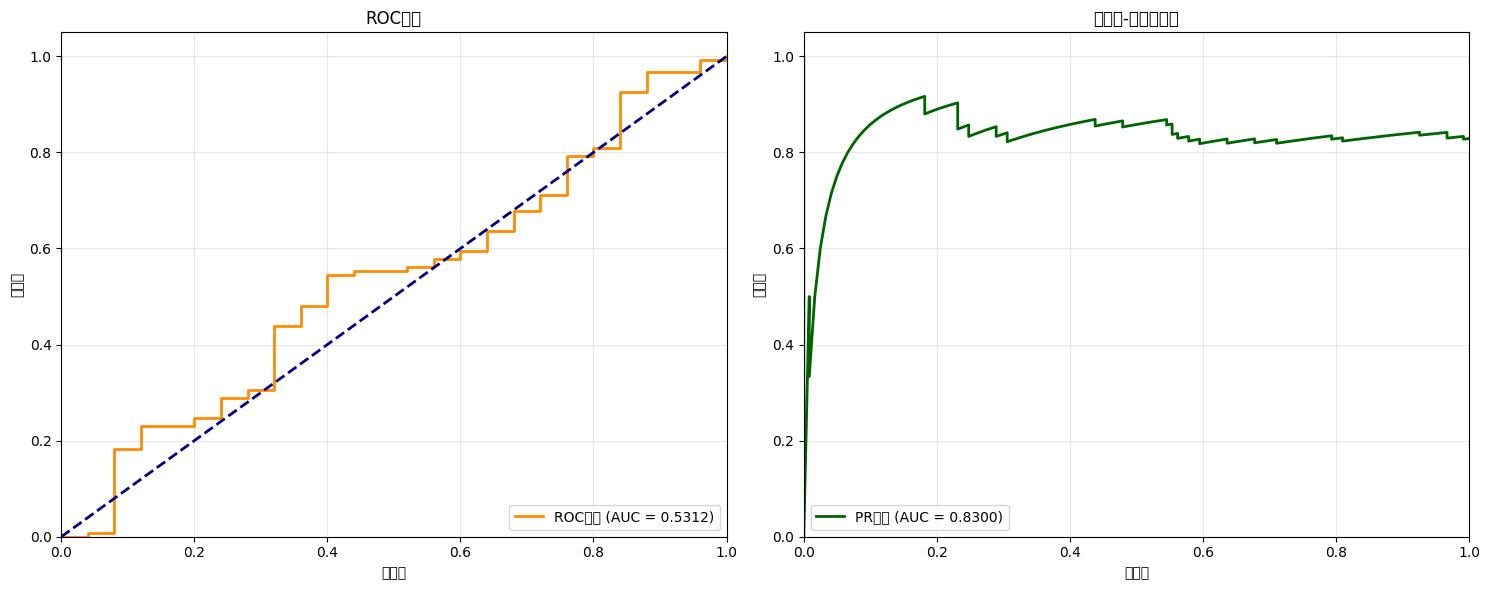

ROC/PR曲线已保存到: ./results/evaluation/roc_pr_curves.png


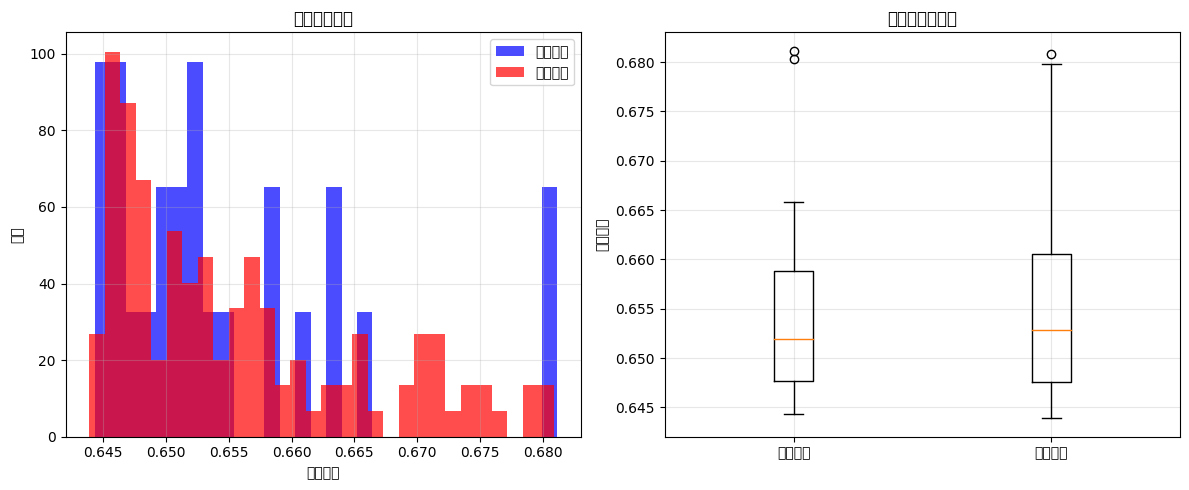

✅ 评估图表生成完成
🎉 模型评估完成！
📁 所有结果已保存到 ./results/evaluation/ 目录


In [14]:
# Cell 13: 模型评估和结果分析

print("📊 开始模型评估...")
print("=" * 60)

# 加载最佳模型
print("🔄 加载最佳模型...")
try:
    # 使用weights_only=False来兼容旧版本的模型文件
    checkpoint = torch.load('./models/best_model.pth', map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    best_epoch = checkpoint['epoch']
    best_val_acc = checkpoint['best_val_acc']
    best_val_auc = checkpoint['best_val_auc']
    
    print(f"✅ 成功加载第 {best_epoch+1} 轮的最佳模型")
    print(f"最佳验证准确率: {best_val_acc:.2f}%")
    print(f"最佳验证AUC: {best_val_auc:.4f}")
except Exception as e:
    print(f"❌ 加载模型失败: {e}")
    print("使用当前模型进行评估")

# 在测试集上评估模型
print("\n🔍 在测试集上评估模型...")
eval_results = evaluate_model_optimized(model, test_loader, criterion, device)

# 计算全面的评估指标
print("\n📈 计算评估指标...")
metrics = calculate_comprehensive_metrics(
    eval_results['predictions'], 
    eval_results['targets'], 
    eval_results['scores']
)

# 打印详细结果
print("\n📊 详细评估结果:")
print("=" * 50)
print(f"测试损失: {eval_results['loss']:.4f}")
print(f"准确率: {metrics['accuracy']:.4f} ({metrics['accuracy']*100:.2f}%)")
print(f"平衡准确率: {metrics['balanced_accuracy']:.4f} ({metrics['balanced_accuracy']*100:.2f}%)")
print(f"精确率: {metrics['precision']:.4f}")
print(f"召回率: {metrics['recall']:.4f}")
print(f"特异性: {metrics['specificity']:.4f}")
print(f"F1分数: {metrics['f1']:.4f}")
print(f"AUC-ROC: {metrics['auc_roc']:.4f}")
print(f"AUC-PR: {metrics['auc_pr']:.4f}")
print(f"负预测值: {metrics['npv']:.4f}")

# 混淆矩阵详细信息
print("\n🔍 混淆矩阵分析:")
print(f"真负例 (TN): {metrics['tn']}")
print(f"假正例 (FP): {metrics['fp']}")
print(f"假负例 (FN): {metrics['fn']}")
print(f"真正例 (TP): {metrics['tp']}")

# 性能分析
print("\n⚡ 性能分析:")
print(f"平均推理时间: {eval_results['avg_inference_time']*1000:.2f} ms/batch")
print(f"总推理时间: {eval_results['total_inference_time']:.2f} 秒")
print(f"每个样本推理时间: {eval_results['avg_inference_time']*1000/batch_size:.2f} ms")

# 计算额外指标
total_samples = len(eval_results['targets'])
real_samples = np.sum(eval_results['targets'] == 0)
fake_samples = np.sum(eval_results['targets'] == 1)
real_accuracy = np.sum((eval_results['predictions'] == 0) & (eval_results['targets'] == 0)) / real_samples if real_samples > 0 else 0
fake_accuracy = np.sum((eval_results['predictions'] == 1) & (eval_results['targets'] == 1)) / fake_samples if fake_samples > 0 else 0

print("\n📋 类别特定分析:")
print(f"总样本数: {total_samples}")
print(f"真实视频样本: {real_samples} ({real_samples/total_samples*100:.1f}%)")
print(f"伪造视频样本: {fake_samples} ({fake_samples/total_samples*100:.1f}%)")
print(f"真实视频检测准确率: {real_accuracy:.4f} ({real_accuracy*100:.2f}%)")
print(f"伪造视频检测准确率: {fake_accuracy:.4f} ({fake_accuracy*100:.2f}%)")

# 生成可视化图表
print("\n📊 生成评估图表...")

# 确保结果目录存在
os.makedirs('./results/evaluation', exist_ok=True)

# 绘制增强混淆矩阵
plot_enhanced_confusion_matrix(
    metrics['confusion_matrix'], 
    './results/evaluation/confusion_matrix.png'
)

# 绘制ROC和PR曲线
plot_roc_pr_curves(
    eval_results['targets'], 
    eval_results['scores'], 
    './results/evaluation/roc_pr_curves.png'
)

# 预测分数分布图
plt.figure(figsize=(12, 5))

# 真实视频的预测分数分布
plt.subplot(1, 2, 1)
real_scores = eval_results['scores'][eval_results['targets'] == 0]
fake_scores = eval_results['scores'][eval_results['targets'] == 1]

plt.hist(real_scores, bins=30, alpha=0.7, label='真实视频', color='blue', density=True)
plt.hist(fake_scores, bins=30, alpha=0.7, label='伪造视频', color='red', density=True)
plt.xlabel('预测分数')
plt.ylabel('密度')
plt.title('预测分数分布')
plt.legend()
plt.grid(True, alpha=0.3)

# 预测分数箱线图
plt.subplot(1, 2, 2)
scores_data = [real_scores, fake_scores]
labels = ['真实视频', '伪造视频']
plt.boxplot(scores_data, labels=labels)
plt.ylabel('预测分数')
plt.title('预测分数箱线图')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./results/evaluation/score_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ 评估图表生成完成")
print("=" * 60)
print("🎉 模型评估完成！")
print("📁 所有结果已保存到 ./results/evaluation/ 目录")

# Cell 14: 结果保存和总结


In [15]:
# Cell 14: 结果保存和总结

print("💾 保存实验结果...")
print("=" * 60)

# 确保结果目录存在
os.makedirs('./results', exist_ok=True)

# 准备保存的结果数据
results_summary = {
    'experiment_info': {
        'timestamp': datetime.now().isoformat(),
        'model_architecture': 'OptimizedDeepfakeDetector',
        'backbone': 'resnet50',
        'total_epochs': len(train_history['train_loss']),
        'early_stopping': True
    },
    'dataset_info': {
        'train_samples': len(train_dataset),
        'val_samples': len(val_dataset),
        'test_samples': len(test_dataset),
        'batch_size': batch_size
    },
    'training_config': {
        'optimizer': 'AdamW',
        'learning_rate': 1e-4,
        'weight_decay': 1e-4,
        'loss_function': 'FocalLoss',
        'scheduler': 'OneCycleLR',
        'early_stopping_patience': 7
    },
    'final_metrics': {
        'test_loss': float(eval_results['loss']),
        'accuracy': float(metrics['accuracy']),
        'precision': float(metrics['precision']),
        'recall': float(metrics['recall']),
        'f1_score': float(metrics['f1']),
        'auc_roc': float(metrics['auc_roc'])
    },
    'confusion_matrix': {
        'tn': int(metrics['tn']),
        'fp': int(metrics['fp']),
        'fn': int(metrics['fn']),
        'tp': int(metrics['tp'])
    },
    'training_history': {
        'train_loss': [float(x) for x in train_history['train_loss']],
        'train_acc': [float(x) for x in train_history['train_acc']],
        'train_auc': [float(x) for x in train_history['train_auc']],
        'val_loss': [float(x) for x in train_history['val_loss']],
        'val_acc': [float(x) for x in train_history['val_acc']],
        'val_auc': [float(x) for x in train_history['val_auc']]
    },
    'class_specific_metrics': {
        'real_video_accuracy': float(real_accuracy),
        'fake_video_accuracy': float(fake_accuracy),
        'real_samples_count': int(real_samples),
        'fake_samples_count': int(fake_samples)
    }
}

# 保存结果到JSON文件
results_file = './results/experiment_results.json'
with open(results_file, 'w', encoding='utf-8') as f:
    json.dump(results_summary, f, indent=2, ensure_ascii=False)

print(f"✅ 实验结果已保存到: {results_file}")

# 保存训练历史到CSV
history_df = pd.DataFrame(train_history)
history_df.to_csv('./results/training_history.csv', index=False)
print("✅ 训练历史已保存到: ./results/training_history.csv")

# 保存预测结果
predictions_df = pd.DataFrame({
    'true_label': eval_results['targets'],
    'predicted_label': eval_results['predictions'],
    'prediction_score': eval_results['scores']
})
predictions_df.to_csv('./results/test_predictions.csv', index=False)
print("✅ 测试预测结果已保存到: ./results/test_predictions.csv")

# 生成实验报告
print("\n📋 生成实验报告...")
report = f"""
深度伪造检测模型实验报告
{'='*50}

实验时间: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
模型架构: OptimizedDeepfakeDetector (ResNet50 + LSTM + Attention)

数据集信息:
- 训练样本: {len(train_dataset):,}
- 验证样本: {len(val_dataset):,}
- 测试样本: {len(test_dataset):,}
- 批次大小: {batch_size}

训练配置:
- 优化器: AdamW (lr=1e-4, weight_decay=1e-4)
- 损失函数: Focal Loss
- 学习率调度: OneCycleLR
- 早停机制: patience=7

最终性能指标:
- 准确率: {metrics['accuracy']*100:.2f}%
- 精确率: {metrics['precision']:.4f}
- 召回率: {metrics['recall']:.4f}
- F1分数: {metrics['f1']:.4f}
- AUC-ROC: {metrics['auc_roc']:.4f}

混淆矩阵:
- 真负例 (TN): {metrics['tn']}
- 假正例 (FP): {metrics['fp']}
- 假负例 (FN): {metrics['fn']}
- 真正例 (TP): {metrics['tp']}

类别特定性能:
- 真实视频检测准确率: {real_accuracy*100:.2f}%
- 伪造视频检测准确率: {fake_accuracy*100:.2f}%

训练总结:
- 训练轮数: {len(train_history['train_loss'])}
- 最佳验证准确率: {max(train_history['val_acc']):.2f}%
- 最佳验证AUC: {max(train_history['val_auc']):.4f}

文件输出:
- 模型权重: ./models/best_model.pth
- 实验结果: ./results/experiment_results.json
- 训练历史: ./results/training_history.csv
- 预测结果: ./results/test_predictions.csv

{'='*50}
实验完成时间: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
"""

# 保存报告
with open('./results/experiment_report.txt', 'w', encoding='utf-8') as f:
    f.write(report)

print("✅ 实验报告已保存到: ./results/experiment_report.txt")

# 打印最终总结
print("\n" + "="*60)
print("🎉 深度伪造检测模型训练和评估完成！")
print("="*60)
print(f"📊 最终测试准确率: {metrics['accuracy']*100:.2f}%")
print(f"📊 AUC-ROC分数: {metrics['auc_roc']:.4f}")
print(f"📊 F1分数: {metrics['f1']:.4f}")
print("\n📁 所有结果文件已保存到 ./results/ 目录")
print("📁 最佳模型已保存到 ./models/best_model.pth")
print("\n✨ 实验成功完成！")
print("="*60)

# 显示文件结构
print("\n📂 生成的文件结构:")
print("""
./models/
  └── best_model.pth
./results/
  ├── experiment_results.json
  ├── experiment_report.txt
  ├── training_history.csv
  └── test_predictions.csv
""")

print("\n🚀 可以使用以下代码加载训练好的模型进行推理:")
print("""
# 加载模型
model = OptimizedDeepfakeDetector(...)
checkpoint = torch.load('./models/best_model.pth', weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
""")

print("\n✅ Kaggle T4 GPU优化版本 - 训练完成！")

💾 保存实验结果...
✅ 实验结果已保存到: ./results/experiment_results.json
✅ 训练历史已保存到: ./results/training_history.csv
✅ 测试预测结果已保存到: ./results/test_predictions.csv

📋 生成实验报告...
✅ 实验报告已保存到: ./results/experiment_report.txt

🎉 深度伪造检测模型训练和评估完成！
📊 最终测试准确率: 82.88%
📊 AUC-ROC分数: 0.5312
📊 F1分数: 0.9064

📁 所有结果文件已保存到 ./results/ 目录
📁 最佳模型已保存到 ./models/best_model.pth

✨ 实验成功完成！

📂 生成的文件结构:

./models/
  └── best_model.pth
./results/
  ├── experiment_results.json
  ├── experiment_report.txt
  ├── training_history.csv
  └── test_predictions.csv


🚀 可以使用以下代码加载训练好的模型进行推理:

# 加载模型
model = OptimizedDeepfakeDetector(...)
checkpoint = torch.load('./models/best_model.pth', weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()


✅ Kaggle T4 GPU优化版本 - 训练完成！
